# Developing scripts for data preparation

In [1]:
import xarray as xr

from pathlib import Path
from src import utils
from src.prepare_data import prepare_dataset, _open

from dask.distributed import Client

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
from src import prepare_data

### Cluster

In [62]:
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

Dask daskboard link: http://10.6.4.33:8787/status


In [ ]:
%%time

config_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/config/prepare_data"
)
save_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/processed"
)
test = prepare_dataset(
    config=f"{config_dir}/AGCD_Australia.yml", save_dir=save_dir, save=True
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
ERROR:fiona._env:PROJ: proj_identify: /g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


caught signal <cdo.Cdo.__getattr__.<locals>.Operator object at 0x14e95ea3ce50> 2 <frame at 0x14e9747bfd40, file '/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/threading.py', line 316, code wait>
caught signal <cdo.Cdo.__getattr__.<locals>.Operator object at 0x14e95ea3ce50> 2 <frame at 0x14e9747bfd40, file '/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/threading.py', line 316, code wait>
caught signal <cdo.Cdo.__getattr__.<locals>.Operator object at 0x14e95ea3ce50> 2 <frame at 0x14e9747bfd40, file '/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/threading.py', line 316, code wait>


In [6]:
# test = xr.open_zarr(
#     "../../data/processed/CAFEf6.daily.anom_1991-2020.t_ref_max_Aus_NRM.zarr"
# )
test = xr.open_zarr("../../data/processed/CAFEf6.daily.full.t_ref_max_Aus_NRM.zarr")

In [51]:
def calculate_percentile_thresholds(ds, percentile, percentile_period):
    """
    Returns the percentile values of ds over a provided period

    Parameters
    ----------
    ds : xarray Dataset
        The data to calculate the percentiles
    percentile : float
        The percentile to calculate
    percentile_period : iterable
        Size 2 iterable containing strings indicating the start and end dates
        of the period over which to calculate the percentile thresholds
    """
    ds_period = utils.mask_period(ds, percentile_period)

    groupby_dim, mean_dim = _get_groupby_and_mean_dims(ds)

    return ds_period.groupby(f"{groupby_dim}.month").quantile(
        q=percentile, dim=mean_dim
    )

In [52]:
def over_percentile_threshold(ds, percentile, percentile_period):
    """
    Find which values in the input array are over a specified percentile
    calculated over a specified period. Returns a boolean array with True
    where values are over the specified percentile and False elsewhere.

    Parameters
    ----------
    ds : xarray Dataset
        The data threshold based in it's percentiles
    percentile : float
        The percentile use to threshold the data
    percentile_period : iterable
        Size 2 iterable containing strings indicating the start and end dates
        of the period over which to calculate the percentile thresholds
    """
    groupby_dim, _ = _get_groupby_and_mean_dims(ds)

    percentile_thresholds = calculate_percentile_thresholds(
        ds, percentile, percentile_period
    )

    return (ds.groupby(f"{groupby_dim}.month") > percentile_thresholds).drop("month")


def under_percentile_threshold(ds, percentile, percentile_period):
    """
    Find which values in the input array are under a specified percentile
    calculated over a specified period. Returns a boolean array with True
    where values are under the specified percentile and False elsewhere.

    Parameters
    ----------
    ds : xarray Dataset
        The data threshold based in it's percentiles
    percentile : float
        The percentile use to threshold the data
    percentile_period : iterable
        Size 2 iterable containing strings indicating the start and end dates
        of the period over which to calculate the percentile thresholds
    """
    groupby_dim, _ = _get_groupby_and_mean_dims(ds)

    percentile_thresholds = calculate_percentile_thresholds(
        ds, percentile, percentile_period
    )

    return (ds.groupby(f"{groupby_dim}.month") < percentile_thresholds).drop("month")

In [60]:
p = over_percentile_threshold(test, 0.9, ["1991-01-01", "2020-12-31"]).compute()

In [55]:
prop_days_over_p90 = utils.coarsen(p, window_size=365, dim="lead")

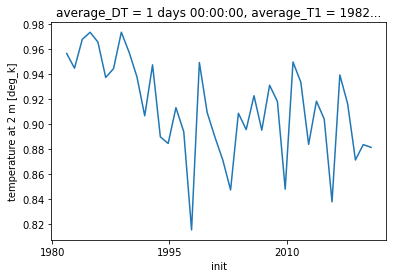

In [59]:
prop_days_over_p90["t_ref_max"].isel(region=0, lead=0).mean("member").plot()

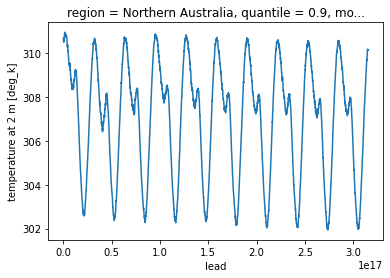

In [13]:
p["t_ref_max"].squeeze().isel(region=0).plot()

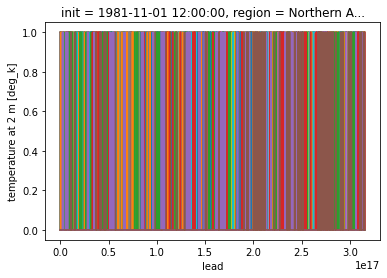

In [22]:
_ = p["t_ref_max"].isel(init=0, region=0).plot.line(x="lead", add_legend=False)

In [147]:
%%time

a = test[0].compute()

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-9547' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/distributed/client.py:1978> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/distributed/client.py", line 1983, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-9540' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/distributed/client.py:1978> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/distributed/client.py", line 1983, in wait
    raise

KeyboardInterrupt: 

# Make sure units are matched

In [103]:
a = xr.open_zarr("../../data/processed/EC_Earth3.annual.full.t_ref_global.zarr")

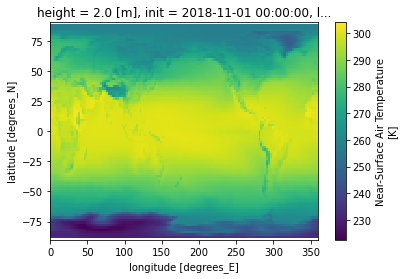

In [104]:
a["t_ref"].isel(init=-1, lead=0, member=0).plot()

In [99]:
b = xr.open_zarr("../../data/processed/JRA55.annual-Jan.full.t_ref_global.zarr")

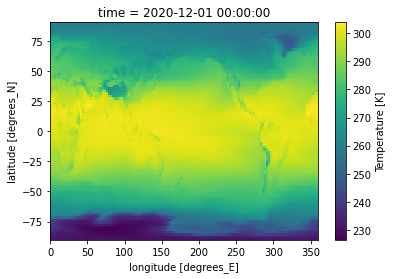

In [100]:
b["t_ref"].isel(time=-1).plot()

In [102]:
region_1 = [140, 215, 25, 45]
region_2 = [170, 270, -10, 10]
region_3 = [150, 200, -50, -15]

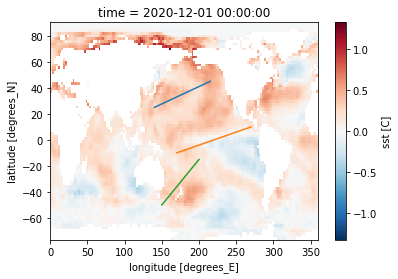

In [105]:
sst_anom["sst"].isel(time=-1).plot()
plt.plot([region_1[0], region_1[1]], [region_1[2], region_1[3]])
plt.plot([region_2[0], region_2[1]], [region_2[2], region_2[3]])
plt.plot([region_3[0], region_3[1]], [region_3[2], region_3[3]])

In [87]:
test = xr.open_zarr(f"{save_dir}/EC_Earth3.t_ref.zarr")

CPU times: user 294 ms, sys: 72.5 ms, total: 366 ms
Wall time: 1.55 s


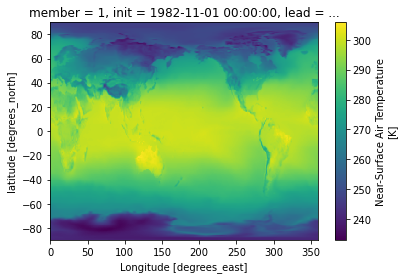

In [84]:
%%time
test["tas"].isel(member=0, init=1, lead=0).plot()

### Process some data

In [4]:
PROJECT_DIR = Path("/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/")

config_dir = PROJECT_DIR / "data/config"
save_dir = PROJECT_DIR / "data/processed"

In [5]:
%%time
prepare_dataset(config_dir / "EN422.yml", save_dir)

CPU times: user 3min 5s, sys: 35.3 s, total: 3min 41s
Wall time: 2min 28s


## Check the data

In [25]:
test = xr.open_zarr("../../data/processed/EN422.annual-Jan.anom_1991-2020.ohc300.zarr")

In [57]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )
        #         all_null = test_rolling.isnull().all(dim=set(test_rolling.dims) - set([dim]))
        #         dss.append(rolling_mean.where(all_null == False, drop=True))
        dss.append(test_rolling.dropna(dim=dim, how="all"))
    return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
test_coarsen = utils.coarsen(
    test,
    window_size=4,
    dim="lead",
)
test_rolling = utils.rolling_mean(
    test,
    window_size=4,
    dim="lead",
)

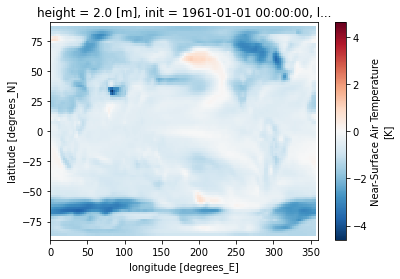

In [21]:
test_coarsen["t_ref"].isel(init=0, lead=1, member=0).plot()

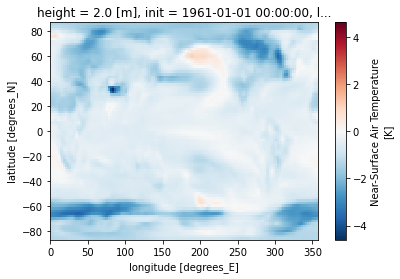

In [24]:
test_rolling["t_ref"].isel(init=0, lead=4, member=0).plot()

In [120]:
test = utils.calculate_amv(sst_anom)

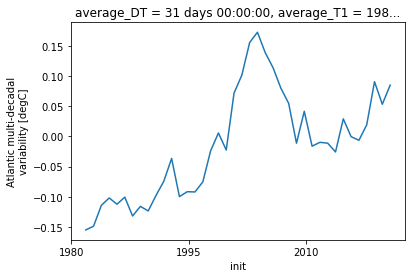

In [124]:
test["amv"].isel(lead=0).mean("member").plot()

In [296]:
ds = "CAFEf6"
var = "ohc300"
test = xr.open_zarr(PROJECT_DIR / f"data/processed/{ds}.{var}.zarr")
test

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, member: 40, time: 55)
Coordinates:
    area     (lat, lon) float64 dask.array<chunksize=(90, 144), meta=np.ndarray>
    height   float64 ...
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) object 1960-12-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    t_ref    (member, time, lat, lon) float32 dask.array<chunksize=(40, 55, 90, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

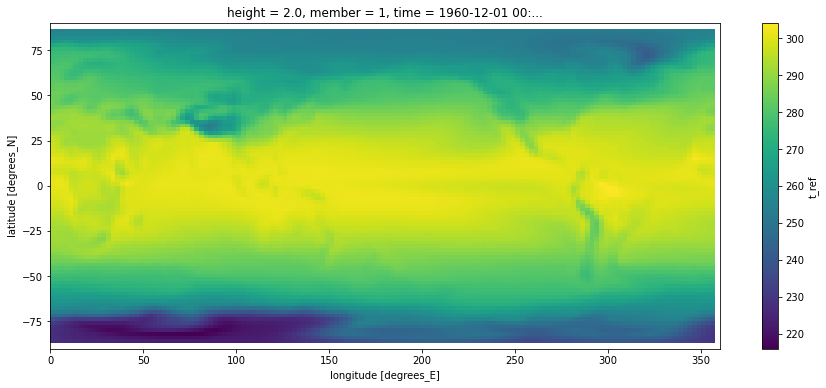

In [297]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
test[var].isel(time=0, member=0).plot()

# Getting rolling working

In [1]:
import xarray as xr
from src import utils

test = xr.open_zarr("../../data/processed/CAFE60v1.annual.anom_1991-2020.t_ref.zarr")

In [6]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )

        return rolling_mean
#         dss.append(rolling_mean.where(rolling_mean.notnull(), drop=True))
#     return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
r = rolling_mean(test, window_size=4)

In [12]:
r.where(r.notnull())

<xarray.Dataset>
Dimensions:  (time: 120, member: 96, lat: 90, lon: 144, latb: 91, lonb: 145)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10 ... 88 89 90 91 92 93 94 95 96
  * time     (time) object 1960-12-01 00:00:00 ... 2020-10-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * latb     (latb) float64 -90.0 -88.99 -86.97 -84.94 ... 86.97 88.99 90.0
  * lonb     (lonb) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Data variables:
    t_ref    (time, member, lat, lon) float64 dask.array<chunksize=(120, 96, 10, 12), meta=np.ndarray>

In [22]:
import xarray as xr
from src import utils
test  = xr.open_zarr("../../data/raw/HadISST/ocean_month.zarr", use_cftime=True).isel(latitude=90, longitude=180)

In [56]:
test_annual = utils.coarsen(test, window_size=12, start_points=["1960-01-01", "1960-11-01"]).compute()
test_4year = rolling_mean(test, window_size=4*12, start_points=["1960-01-01"]).isel(time=slice(None,None,12)).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [60]:
test = xr.open_zarr("../../data/processed/HadISST.annual-Jan.anom_1985-2014.sst.zarr")

In [62]:
rolling_mean(test, window_size=4)

<xarray.Dataset>
Dimensions:  (time: 58, lat: 83, lon: 144)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
  * lat      (lat) float64 -75.84 -73.82 -71.8 -69.78 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1963-12-01 00:00:00 ... 2020-12-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
Data variables:
    sst      (time, lat, lon) float64 dask.array<chunksize=(58, 3, 12), meta=np.ndarray>

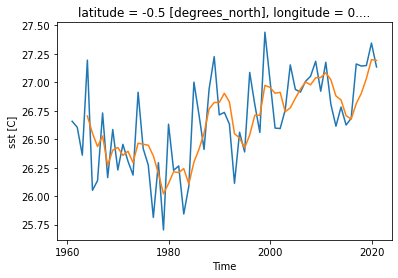

In [44]:
test_annual["sst"].plot()
test_4year["sst"].plot()

In [49]:
test_annual_anom = utils.anomalise(test_annual, ["1991-01-01", "2020-12-31"])

In [50]:
test_4annual_anom = rolling_mean(test_annual_anom, window_size=4)

In [55]:
test_4annual_anom

<xarray.Dataset>
Dimensions:    (time: 58, nv: 2)
Coordinates:
    latitude   float32 -0.5
    longitude  float32 0.5
  * time       (time) object 1963-12-16 12:00:00 ... 2020-12-16 12:00:00
Dimensions without coordinates: nv
Data variables:
    sst        (time) float32 -0.1737 -0.3251 -0.4424 ... 0.1554 0.3207 0.3141
    time_bnds  (time, nv) float32 -1.607e+04 -1.607e+04 ... 4.748e+03 4.749e+03

In [51]:
test_4year_anom = utils.anomalise(test_4year, ["1991-01-01", "2020-12-31"])

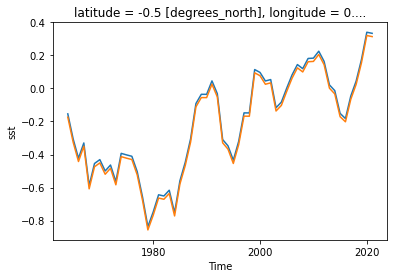

In [52]:
test_4year_anom["sst"].plot()
test_4annual_anom["sst"].plot()